In [1]:
# load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from time import sleep
from IPython.display import clear_output
from collections import Counter

In [2]:
#Define wind force class names
wind_force_class_names = ["No wind","Weak wind force","Middle wind force","Strong wind force"]

In [3]:
# fun to crop img
def fn_crop_image(img_array, y_start, x_start):
    y_heigth = 60
    x_width = 110
    
    crop_image = img_array[y_start:y_start+y_heigth,x_start:x_start+x_width] # set RGB to 0 to only analyze red chanel
    return crop_image

# fun to resize img
# to do if further dimension reduction is desired
    

In [4]:
# define data directory
DATADIR = "../data/Originals/"

# import labels
label_df = pd.read_csv("../data/labels_old_camera.csv")
label_df = label_df.rename(columns={"Unnamed: 0": "img"})

# retain only labels / img with meaningful label
label_df = label_df[label_df["wind_force"] != "0"]

# array with img names of labeled img
labeled_img = label_df["img"].to_numpy()

# create numeric wind force variable
label_df["wind_force_num"] = np.where(label_df["wind_force"] == "n", 0,
                             np.where(label_df["wind_force"] == "w", 1,
                             np.where(label_df["wind_force"] == "m", 2,
                             np.where(label_df["wind_force"] == "s", 3, -1))))


In [5]:
#Create Training Data
training_data = []

#Set True to harmonize amount of pictures per label (multiply pictures and labels)
harmonize = True
# Get count per label value and calculate factors for harmonizing amounts
label_value_counts = label_df["wind_force_num"].value_counts()

maxLabels = label_value_counts.max()
factor0 = round(maxLabels / label_value_counts.loc[0])
factor1 = round(maxLabels / label_value_counts.loc[1])
factor2 = round(maxLabels / label_value_counts.loc[2])
factor3 = round(maxLabels / label_value_counts.loc[3])
if harmonize:
  print(f"factors for 0,1,2,3 category: {factor0,factor1,factor2,factor3}")


def create_training_data():
    for img in labeled_img:
        path = os.path.join(DATADIR, img)
        img_array = cv2.imread(os.path.join(path))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB) # from BGR to RGB
        new_array = fn_crop_image(img_array, 250, 570)
        wind_label = label_df.loc[label_df["img"] == img, "wind_force_num"] # get label to coresponding img
        wind_label = np.ndarray.item(wind_label.to_numpy()) # convert to single scalar integer
        if harmonize:
          if wind_label == 0: #No wind
            for i in range(factor0):
              training_data.append([new_array, wind_label])
          if wind_label == 1: #Middle wind
            for i in range(factor1):
              training_data.append([new_array, wind_label])
          if wind_label == 2: #Middle wind
            for i in range(factor2):
              training_data.append([new_array, wind_label])
          if wind_label == 3: #Strong wind
            for i in range(factor3):
              training_data.append([new_array, wind_label])
        else:
          training_data.append([new_array, wind_label])
    
create_training_data()

factors for 0,1,2,3 category: (5, 1, 2, 23)


In [6]:
images = []
labels = []

for feature, label in training_data:
    images.append(feature)
    labels.append(label)

# mutate to np.array
np_images = np.array(images).reshape(-1, np.array(images).shape[1], np.array(images).shape[2], np.array(images).shape[3])
np_labels = np.array(labels)

#Check counts of labels
Counter(np_labels)


Counter({1: 162, 0: 155, 2: 136, 3: 161})

Train Machine Learning Models

In [7]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.inspection import permutation_importance

# common visualization module
#import plotly.express as px
#import seaborn as sns
#sns.set()

from time import time as timer
import tarfile

#import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [8]:
#Convert image shape and split to train and test set
label_amount = np_labels.size

print(f"np_images shape: {np_images.shape}")
np_images_red = np_images[:,:,:,0] #reduce to red channel
print(f"np_images_red shape: {np_images_red.shape}")

np_images_red_flatten = np_images_red[:label_amount,:].reshape(label_amount,-1)
print(f"np_images_red_flatten shape: {np_images_red_flatten.shape}")

#1) Split into train and test set: HEADS-UP: RANDOM_STATE set to 7 for reproducable results..
x_train, x_test, y_train, y_test = train_test_split(np_images_red_flatten, np_labels, test_size=0.2,random_state=7)

print(f"np_labels shape: {np_labels.shape}")

np_images shape: (614, 60, 110, 3)
np_images_red shape: (614, 60, 110)
np_images_red_flatten shape: (614, 6600)
np_labels shape: (614,)


In [9]:
#Linear Model - Logistic Regression
#1 Create classifier
multi_class='multinomial'
clf = linear_model.LogisticRegression(solver='sag', max_iter=200, multi_class='multinomial', )
# fit the model
clf.fit(x_train, y_train)
#print(x_train.shape) --> 

#Evaluate accuracy on train and test datasets
print("training accuracy : %.3f (%s)" % (clf.score(x_train, y_train), multi_class))
print("Test accuracy : %.3f (%s)" % (clf.score(x_test, y_test), multi_class))

training accuracy : 1.000 (multinomial)
Test accuracy : 0.992 (multinomial)


/Users/Christine/OneDrive/Dokumente/CAS Data Science/M3 Machine Learning Moentschele/SourceCodeMoentschele/MoentscheleSourceCode/moentschele_project/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [15]:
#Check wrong predictions
y_test_pred = clf.predict(x_test)

wrong_pred = []
for i in range(y_test.size):
  if y_test[i] != y_test_pred[i]:
    wrong_pred.append(i)
wrong_pred

[51]

Label: Weak wind force
Prediction: No wind
Sorry, not correct!


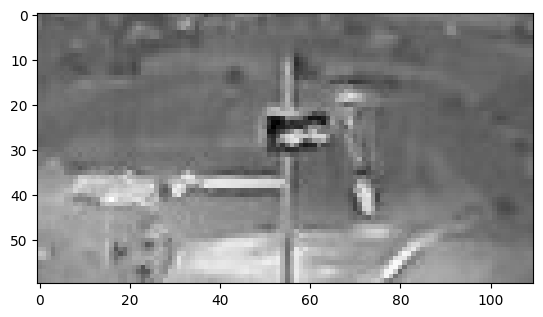

In [16]:
#Have a look at predicitions
idx = 51
plt.grid(False)
plt.imshow(x_test[idx].reshape(60,110),cmap='gray')
c_true = y_test[idx]
c_pred = y_test_pred[idx]
print('Label:', wind_force_class_names[c_true])
print('Prediction:', wind_force_class_names[c_pred])
#To do: can we somehow find out the original filename. Would be nice to correct wrong labels..
if c_true == c_pred:
  print('Hurray! :-)')
else:
  print('Sorry, not correct!')

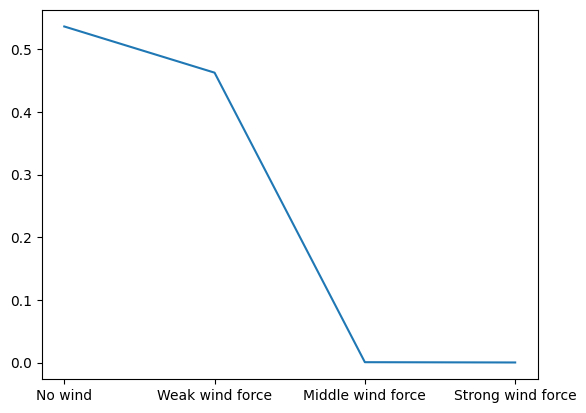

In [17]:
#Plot probabilities for previously selected idx:
y_test_pred_p = clf.predict_proba(x_test)
plt.plot(wind_force_class_names, y_test_pred_p[idx])